<a href="https://colab.research.google.com/github/Hussien-Sayed/Earthquake-Modelling/blob/main/LGBM_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Load the data

In [ ]:
!pip install contextily
!pip install optuna

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve
from sklearn.preprocessing import MinMaxScaler
import optuna


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Default Experiment config
n_clusters = 60
Task_type = "Regression" # "Classification","Regression"
use_log = False          # only in Reg
th = 0.5                 # only in cls
undersample = False
OH_clusters = False

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/EM/updated_minable_SEOD.csv")

## Cluster The Data

In [ ]:
def calculate_clustering(df,n_clusters=60, normalized=False,):
    """
    Function to calculate clustering of the dataframe based on latitude and longitude
    Args:
        df: Dataframe
        normalized: (Boolean). Whether to normalized data or not before the clustering.

    Returns:Dataframe with cluster_label as new column.

    """
    df.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
    coords = df[['latitude', 'longitude']]
    if normalized:
        scaler = MinMaxScaler()
        coords = scaler.fit_transform(coords)
    kmeans = KMeans(n_clusters =n_clusters , init ='k-means++')
    kmeans.fit(coords) # Compute k-means clustering.
    df['cluster_label'] = kmeans.fit_predict(coords)
    labels = kmeans.predict(coords) # Labels of each point
    centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
    return df

In [ ]:
df = calculate_clustering(df,n_clusters=n_clusters, normalized=False)

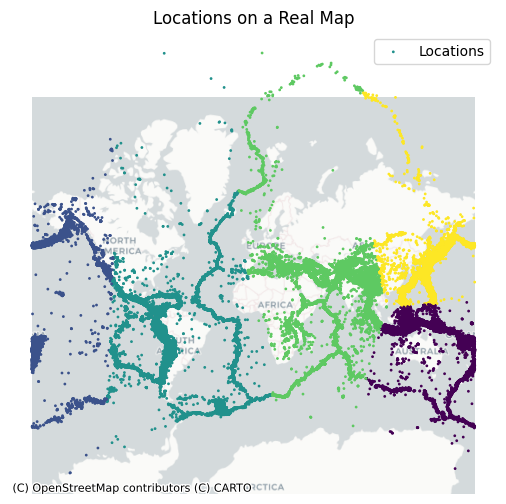

In [ ]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip") #"https://data.buffalony.gov/resource/d6g9-xbgu.geojson"

gdf = gpd.sjoin(gdf, world, how="left", predicate="within")

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax,column='cluster_label', cmap='viridis', markersize=1, label="Locations")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # You can change the basemap provider
ax.set_title("Locations on a Real Map")
ax.legend()
ax.set_axis_off()
plt.show()


## Complete the Data

In [ ]:
#define day_frac
time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))
df["day_frac"] = (time_value.dt.hour * 3600 + time_value.dt.minute * 60 + time_value.dt.second)/ (24 * 60 * 60)


<ipython-input-14-2f802f072179>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_value = pd.to_datetime(df.time.apply(lambda x:x.split()[1]).apply(lambda x:x.split("+")[0]))


In [ ]:
# define a row for all clusters for all days
filled_data = df[['year','month','day']].copy()
filled_data.drop_duplicates(inplace=True)
filled_data_clusters = filled_data.loc[filled_data.index.repeat(n_clusters)].reset_index(drop=True)
filled_data_clusters["cluster_label"] = np.tile(np.arange(n_clusters), len(filled_data)).astype("int32")

#define cols to be merged with the filled_data_clusters
non_cluster_cols = df.columns.difference(['latitude', 'longitude', 'depth', 'mag','cluster_label',"time","day_frac"])

#,'ill_frac_interpolated','r/km_interpolated', 'dec_interpolated','ra/h_interpolated',
#'ra/°_interpolated', 'td_acc_interpolated',

#define cols to be aggregated
cluster_cols = df.columns.difference(non_cluster_cols).tolist() + ['year','month','day']
cluster_cols.remove("time")

filled_data_clusters = filled_data_clusters.merge(df[non_cluster_cols].drop_duplicates(),how ="left",on=['year','month','day'])
n_earthquakes = df[cluster_cols].groupby(['year','month','day','cluster_label']).day.count().rename("n_earthquakes")
agg_df_per_cluster = df[cluster_cols].groupby(['year','month','day','cluster_label']).mean()
agg_df_per_cluster = pd.concat((agg_df_per_cluster,n_earthquakes),axis=1).reset_index()
filled_data_clusters = filled_data_clusters.merge(agg_df_per_cluster,how ="left",on=['year','month','day','cluster_label'])

filled_data_clusters["mag"] = filled_data_clusters["mag"].fillna(0)
filled_data_clusters["n_earthquakes"] = filled_data_clusters["n_earthquakes"].fillna(0)
nan_cols = filled_data_clusters.columns[filled_data_clusters.isna().any(axis=0)]

filled_data_clusters[nan_cols] = filled_data_clusters[nan_cols].fillna(filled_data_clusters.groupby(['year','month','day'])[nan_cols].transform('mean'))

# inverse clusters to sample locations for generated data of non-existing Earthquakes
for cluster_ix in tqdm(filled_data_clusters.cluster_label.unique()):
    df_to_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] == 0)
    df_from_fill_ix = (filled_data_clusters["cluster_label"] == cluster_ix)&(filled_data_clusters["n_earthquakes"] != 0)
    n_samples = sum(df_to_fill_ix)
    filled_data_clusters.loc[df_to_fill_ix, ["latitude","longitude"] ] = \
    filled_data_clusters.loc[df_from_fill_ix, ["latitude","longitude"] ].sample(n_samples,replace=True).values

#define random values for day_frac of non-existing Earthquakes
filled_data_clusters.loc[filled_data_clusters.mag==0,"day_frac"] = np.random.rand((filled_data_clusters.mag==0).sum())

#define intrp values
delta = filled_data_clusters[['ill_frac_1','r/km_1','dec_1','ra/h_1','ra/°_1','td_acc_1']].values - filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values
filled_data_clusters[['ill_frac_interpolated','r/km_interpolated','dec_interpolated','ra/h_interpolated','ra/°_interpolated','td_acc_interpolated']] = filled_data_clusters[['ill_frac','r/km','dec','ra/h','ra/°','td_acc']].values + delta * filled_data_clusters.day_frac.values.reshape(-1,1)


#remove range(4.5-4.8) from being considered as earthquake
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"n_earthquakes"] = 0
filled_data_clusters.loc[filled_data_clusters.mag<4.8,"mag"] = 0

#fill 0 values eathquake magnitude with a distribution for un noticed earthquake magnitudes
#ix1 = np.arange(0,1.7,0.00671)
#ix2 = np.arange(1.7,4.5,0.00671)

#val1 = [3.5]*len(ix1)
#val2 = np.linspace(3.5,1,len(ix2))
#ix = np.hstack((ix1,ix2))
#val = np.hstack((val1,val2))
#val = np.power(10,val)

#gen_dist = []
#for i,v in zip(ix,val):
#    gen_dist.extend([i]*int(v))
#np.random.shuffle(gen_dist)

#filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = gen_dist[:(filled_data_clusters.mag==0).sum()]
filled_data_clusters.loc[filled_data_clusters.mag==0,"mag"] = 2.4  #median value

100%|██████████| 5/5 [00:00<00:00, 79.75it/s]


## Feature Engineering

In [ ]:
# remove useless columns
filled_data_clusters.drop(['dec', 'dec_1',
 'ill_frac', 'ill_frac_1',
 'r/km', 'r/km_1',
 'ra/h', 'ra/h_1',
 'ra/°','ra/°_1',
 'td_acc', 'td_acc_1',
 ],axis=1,inplace=True)


In [ ]:
# Normalize
cols_to_normalize = ['acum_day','ill_frac_interpolated', 'r/km_interpolated', 'dec_interpolated',
       'ra/h_interpolated', 'ra/°_interpolated', 'td_acc_interpolated']

scaler = MinMaxScaler()
filled_data_clusters[cols_to_normalize] = scaler.fit_transform(filled_data_clusters[cols_to_normalize])


In [ ]:
#OneHot encoding
if OH_clusters:
    one_hot_df = pd.get_dummies(filled_data_clusters.cluster_label)
    one_hot_df.columns = [f"cluster_{i}" for i in range(0,one_hot_df.shape[1])]
    filled_data_clusters = pd.concat((filled_data_clusters,one_hot_df),axis=1)


## Regression Model

In [ ]:
if Task_type == "Regression":
    exclude_from_train = ['depth', 'mag', 'n_earthquakes']
    X = filled_data_clusters[filled_data_clusters.columns.difference(exclude_from_train)].copy()
    y = filled_data_clusters['mag'].copy()

    X_test  = X[X.year>=2015].copy()
    y_test = y[X.year>=2015].copy()

    X_tv = X[X.year<2015].copy()
    y_tv = y[X.year<2015].copy()


    if undersample:
        ix_org = y_tv>=4.8
        ix_gen = y_tv<4.8

        n_samples = sum(ix_org)
        ix_gen_sampled = y_tv[ix_gen].sample(n_samples).index
        ix_org = y_tv[ix_org].index

        full_ix = ix_gen_sampled.append(ix_org)

        X_tv = X_tv.loc[full_ix]
        y_tv = y_tv.loc[full_ix]
        X_tv = X_tv.sample(frac=1)
        y_tv = y_tv.sample(frac=1)

    #Dummy Socre
    print("dummy_score")
    dummy_score = mean_absolute_error(y_test, np.repeat(np.median(y_test),len(y_test)))
    print(dummy_score)
    X_train, X_val, y_train, y_val = train_test_split(X_tv,y_tv, test_size=0.2, random_state=42)

    def objective(trial):

        params = {
        "objective": "regression",
        "metric": "mae",
        'verbose': 0,

        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        }


        if use_log:
            lgb_train = lgb.Dataset(X_train, label=np.log(y_train))
            lgb_val =  lgb.Dataset(X_val, label=np.log(y_val), reference=lgb_train)
        else:
            lgb_train = lgb.Dataset(X_train, label=y_train)
            lgb_val =  lgb.Dataset(X_val, label=y_val, reference=lgb_train)


        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=10000,
            callbacks=[lgb.early_stopping(stopping_rounds=100)],
        )

        if use_log:
            y_pred = np.exp(model.predict(X_test))
        else:
            y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        print(mae)

        return mae


    study = optuna.create_study(direction='minimize')  # Minimize the mean squared error
    study.optimize(objective, n_trials=20)  # Number of trials to run


In [ ]:
if Task_type == "Regression":

    if use_log:
        lgb_train = lgb.Dataset(X_train, label=np.log(y_train))
        lgb_val =  lgb.Dataset(X_val, label=np.log(y_val), reference=lgb_train)
    else:
        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_val =  lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    pars = {}
    pars = study.best_params
    pars["objective"] = "regression"
    pars["metric"] = "mae"

    model = lgb.train(
        pars,
        lgb_train,
        valid_sets=[lgb_val],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(stopping_rounds=100)],
    )

    if use_log:
        y_pred = np.exp(model.predict(X_test))
    else:
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    print(mae)



    threshold = 4.8  # Example threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    y_test_binary = (y_test >= threshold).astype(int)


    cm = confusion_matrix(y_test_binary, y_pred_binary)
    cm_norm = cm / np.repeat([[(y_test_binary==0).sum(),(y_test_binary==1).sum()]],2,axis=0).T
    FP,TP = cm_norm[:,1]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    feature_importances =  model.feature_importance()
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    importance_df.to_csv("feature_importance.csv",index=False)


## Classification Model

In [ ]:
if Task_type == "Classification":

    exclude_from_train = ['depth', 'mag', 'n_earthquakes']
    X = filled_data_clusters[filled_data_clusters.columns.difference(exclude_from_train)].copy()
    y = filled_data_clusters['mag'].copy()
    y = (y>=4.8).astype("int")

    X_test  = X[X.year>=2015].copy()
    y_test = y[X.year>=2015].copy()

    X_tv = X[X.year<2015].copy()
    y_tv = y[X.year<2015].copy()


    if undersample:
        ix_org = y_tv==1
        ix_gen = y_tv==0

        n_samples = sum(ix_org)
        ix_gen_sampled = y_tv[ix_gen].sample(n_samples).index
        ix_org = y_tv[ix_org].index

        full_ix = ix_gen_sampled.append(ix_org)

        X_tv = X_tv.loc[full_ix]
        y_tv = y_tv.loc[full_ix]
        X_tv = X_tv.sample(frac=1)
        y_tv = y_tv.sample(frac=1)

    #Dummy score
    print("dummy_score")
    dummy_score = accuracy_score(y_test, np.repeat(np.median(y_test),len(y_test)))
    print(dummy_score)
    X_train, X_val, y_train, y_val = train_test_split(X_tv,y_tv, test_size=0.2, random_state=42)


    def objective(trial):

        params = {
        'objective': 'binary',  #'multiclass',
        'metric': 'binary_logloss', #'multi_logloss',
        'verbose': 0,

        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "num_leaves": trial.suggest_int("num_leaves", 10, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        }

        lgb_train = lgb.Dataset(X_train, label=y_train)
        lgb_val =  lgb.Dataset(X_val, label=y_val, reference=lgb_train)


        model = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_val],
            num_boost_round=10000,
            callbacks=[lgb.early_stopping(stopping_rounds=100)],
        )


        y_pred_proba = model.predict(X_test)
        thresholds = np.linspace(0, 1, 100)  # Vary threshold from 0 to 1
        accuracies = []

        for t in thresholds:
            y_pred = (y_pred_proba >= t).astype(int)  # Apply threshold
            accuracies.append(accuracy_score(y_test, y_pred))

        # Find the best threshold
        best_threshold = thresholds[np.argmax(accuracies)]
        best_accuracy = max(accuracies)
        print("best_accuracy: ",best_accuracy,"best_threshold: ",best_threshold)

        return best_accuracy

    study = optuna.create_study(direction='maximize')  # Minimize the mean squared error
    study.optimize(objective, n_trials=20)  # Number of trials to run


[I 2025-03-01 04:43:25,664] A new study created in memory with name: no-name-38393044-2b0d-467a-bf4b-50a1b43ed009


dummy_score
0.6434381778741866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's binary_logloss: 0.588652


[I 2025-03-01 04:43:33,648] Trial 0 finished with value: 0.6454446854663775 and parameters: {'learning_rate': 0.018523984853667703, 'max_depth': 12, 'num_leaves': 103, 'lambda_l1': 9.495414671045454, 'lambda_l2': 0.037055016085879654, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.6454446854663775.


best_accuracy:  0.6454446854663775 best_threshold:  0.48484848484848486


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-03-01 05:36:18,714] Trial 1 finished with value: 0.6460412147505423 and parameters: {'learning_rate': 0.002550912929629959, 'max_depth': 17, 'num_leaves': 111, 'lambda_l1': 4.122944208985355, 'lambda_l2': 5.244461546482501, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.6460412147505423.


best_accuracy:  0.6460412147505423 best_threshold:  0.494949494949495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2654]	valid_0's binary_logloss: 0.588723


[I 2025-03-01 05:37:17,632] Trial 2 finished with value: 0.645824295010846 and parameters: {'learning_rate': 0.0020106791928919707, 'max_depth': 11, 'num_leaves': 94, 'lambda_l1': 3.521608850412704, 'lambda_l2': 4.983297672779056, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.6460412147505423.


best_accuracy:  0.645824295010846 best_threshold:  0.48484848484848486


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-01 06:33:05,987] Trial 3 finished with value: 0.6445770065075922 and parameters: {'learning_rate': 0.0005053331196866394, 'max_depth': 11, 'num_leaves': 176, 'lambda_l1': 9.836118385099525, 'lambda_l2': 8.737526055736545, 'boosting_type': 'dart'}. Best is trial 1 with value: 0.6460412147505423.


best_accuracy:  0.6445770065075922 best_threshold:  0.494949494949495
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-03-01 06:34:08,331] Trial 4 finished with value: 0.6461496746203904 and parameters: {'learning_rate': 0.001942422883090005, 'max_depth': 10, 'num_leaves': 174, 'lambda_l1': 0.9124554383855714, 'lambda_l2': 6.297073133289068, 'boosting_type': 'gbdt'}. Best is trial 4 with value: 0.6461496746203904.


best_accuracy:  0.6461496746203904 best_threshold:  0.48484848484848486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2025-03-01 06:34:55,801] Trial 5 finished with value: 0.6454446854663775 and parameters: {'learning_rate': 0.0033600015138148622, 'max_depth': 6, 'num_leaves': 140, 'lambda_l1': 7.572833835605628, 'lambda_l2': 6.701235573817896, 'boosting_type': 'gbdt'}. Best is trial 4 with value: 0.6461496746203904.


best_accuracy:  0.6454446854663775 best_threshold:  0.5252525252525253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-01 06:35:05,737] Trial 6 finished with value: 0.6468004338394794 and parameters: {'learning_rate': 0.031889448294016076, 'max_depth': 3, 'num_leaves': 109, 'lambda_l1': 2.5851254145083304, 'lambda_l2': 4.126715494514409, 'boosting_type': 'gbdt'}. Best is trial 6 with value: 0.6468004338394794.


best_accuracy:  0.6468004338394794 best_threshold:  0.5151515151515152


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-03-01 07:31:38,050] Trial 7 finished with value: 0.6441431670281995 and parameters: {'learning_rate': 0.0005875590946953736, 'max_depth': 19, 'num_leaves': 157, 'lambda_l1': 8.179073471364855, 'lambda_l2': 7.443676469969761, 'boosting_type': 'dart'}. Best is trial 6 with value: 0.6468004338394794.


best_accuracy:  0.6441431670281995 best_threshold:  0.5050505050505051


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-03-01 08:28:15,260] Trial 8 finished with value: 0.6457700650759219 and parameters: {'learning_rate': 0.0009600672870880613, 'max_depth': 17, 'num_leaves': 149, 'lambda_l1': 9.403253287069491, 'lambda_l2': 2.665098546830181, 'boosting_type': 'dart'}. Best is trial 6 with value: 0.6468004338394794.


best_accuracy:  0.6457700650759219 best_threshold:  0.5050505050505051


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-03-01 09:03:41,079] Trial 9 finished with value: 0.6475054229934925 and parameters: {'learning_rate': 0.0040239700176718735, 'max_depth': 5, 'num_leaves': 168, 'lambda_l1': 2.2997177174636567, 'lambda_l2': 3.49304635747326, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6475054229934925 best_threshold:  0.5555555555555556


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-03-01 09:39:51,308] Trial 10 finished with value: 0.6434381778741866 and parameters: {'learning_rate': 4.102616687850146e-05, 'max_depth': 6, 'num_leaves': 28, 'lambda_l1': 0.09191758739480171, 'lambda_l2': 1.955607724346308, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6434381778741866 best_threshold:  0.0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-03-01 09:39:56,176] Trial 11 finished with value: 0.6467462039045553 and parameters: {'learning_rate': 0.04867581247299114, 'max_depth': 3, 'num_leaves': 62, 'lambda_l1': 2.280342813130884, 'lambda_l2': 3.54931048363322, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6467462039045553 best_threshold:  0.5151515151515152
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[I 2025-03-01 09:40:17,063] Trial 12 finished with value: 0.6462039045553145 and parameters: {'learning_rate': 0.01555689463316192, 'max_depth': 3, 'num_leaves': 188, 'lambda_l1': 5.83666636479641, 'lambda_l2': 4.152282254152844, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6462039045553145 best_threshold:  0.48484848484848486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-03-01 10:30:15,647] Trial 13 finished with value: 0.6440347071583514 and parameters: {'learning_rate': 0.08184044390050205, 'max_depth': 7, 'num_leaves': 126, 'lambda_l1': 2.1712494027344524, 'lambda_l2': 1.313310677033468, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6440347071583514 best_threshold:  0.11111111111111112
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[931]	valid_0's binary_logloss: 0.588589


[I 2025-03-01 10:30:33,725] Trial 14 finished with value: 0.6452819956616052 and parameters: {'learning_rate': 0.008612643384071693, 'max_depth': 8, 'num_leaves': 70, 'lambda_l1': 5.777429050598741, 'lambda_l2': 3.3291392203901387, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6452819956616052 best_threshold:  0.4545454545454546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-03-01 10:58:05,485] Trial 15 finished with value: 0.6442516268980477 and parameters: {'learning_rate': 0.0001503329915390067, 'max_depth': 4, 'num_leaves': 200, 'lambda_l1': 2.414211194707313, 'lambda_l2': 9.677133277838404, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6442516268980477 best_threshold:  0.5252525252525253


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-03-01 11:44:33,400] Trial 16 finished with value: 0.6459869848156182 and parameters: {'learning_rate': 0.008000683348870092, 'max_depth': 14, 'num_leaves': 74, 'lambda_l1': 3.8457354380433597, 'lambda_l2': 4.728451898186196, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6459869848156182 best_threshold:  0.4545454545454546
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[551]	valid_0's binary_logloss: 0.590051


[I 2025-03-01 11:44:39,411] Trial 17 finished with value: 0.6464208242950108 and parameters: {'learning_rate': 0.0355995687925542, 'max_depth': 5, 'num_leaves': 13, 'lambda_l1': 1.396961717774032, 'lambda_l2': 0.8909789627862388, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6464208242950108 best_threshold:  0.5353535353535354


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2025-03-01 12:39:11,423] Trial 18 finished with value: 0.6445770065075922 and parameters: {'learning_rate': 0.00022587357187641615, 'max_depth': 8, 'num_leaves': 127, 'lambda_l1': 4.899480903794344, 'lambda_l2': 2.5726577734940617, 'boosting_type': 'dart'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.6445770065075922 best_threshold:  0.494949494949495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1111]	valid_0's binary_logloss: 0.589068


[I 2025-03-01 12:39:28,549] Trial 19 finished with value: 0.645824295010846 and parameters: {'learning_rate': 0.0064426037637989155, 'max_depth': 9, 'num_leaves': 39, 'lambda_l1': 3.015296003494529, 'lambda_l2': 6.145876983856599, 'boosting_type': 'gbdt'}. Best is trial 9 with value: 0.6475054229934925.


best_accuracy:  0.645824295010846 best_threshold:  0.5252525252525253


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

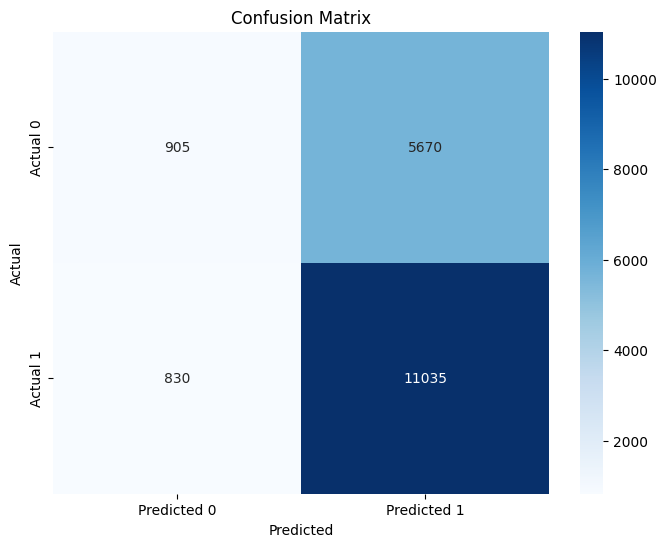

In [ ]:
if Task_type == "Classification":

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val =  lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    pars = {}
    pars = study.best_params
    pars["objective"] = "binary"
    pars["metric"] = "binary_logloss"


    model = lgb.train(
        pars,
        lgb_train,
        valid_sets=[lgb_val],
        num_boost_round=10000,
        callbacks=[lgb.early_stopping(stopping_rounds=100)],
    )



    y_pred_proba = model.predict(X_test)
    thresholds = np.linspace(0, 1, 100)  # Vary threshold from 0 to 1
    accuracies = []

    for t in thresholds:
        y_pred = (y_pred_proba >= t).astype(int)  # Apply threshold
        accuracies.append(accuracy_score(y_test, y_pred))

    # Find the best threshold
    best_threshold = thresholds[np.argmax(accuracies)]
    best_accuracy = max(accuracies)

    print("best_accuracy: ",best_accuracy,"best_threshold: ",best_threshold)

    y_pred = y_pred_proba > best_threshold

    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm / np.repeat([[(y_test==0).sum(),(y_test==1).sum()]],2,axis=0).T
    FP,TP = cm_norm[:,1]


    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


    feature_importances =  model.feature_importance()
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    importance_df.to_csv("feature_importance.csv",index=False)
